In [1]:
import os 
from PIL import Image
import cv2
import numpy as np
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
import matplotlib
import matplotlib.pyplot as plt
import imageio

#import tkinter
#matplotlib.use('TkAgg')

from skimage.measure import ransac
from skimage.transform import ProjectiveTransform
from skimage.transform import AffineTransform

##############################################

from pathlib import Path
import random
import matplotlib.cm as cm
import torch

from models.matching import Matching
#from models.utils import (compute_pose_error, compute_epipolar_error,
#                          estimate_pose, make_matching_plot,
#                          error_colormap, AverageTimer, pose_auc, read_image,
#                          rotate_intrinsics, rotate_pose_inplane,
#                          scale_intrinsics)

#from models.utils import read_image

torch.set_grad_enabled(False)




In [2]:
print('hola')

hola


In [3]:
# Parametres

cache=False
eval=False
fast_viz=False
force_cpu=False
input_dir='assets/pair/'
input_pairs='assets/pair.txt'
keypoint_threshold=0.005
match_threshold=0.2
max_keypoints=1024
max_length=-1
nms_radius=4
opencv_display=False
output_dir='resultat'
resize=[640, 480]
resize_float=False
show_keypoints=False
shuffle=False
sinkhorn_iterations=20
superglue='outdoor'
viz=True
viz_extension='jpg'

In [4]:
assert not (opencv_display and not viz), 'Must use --viz with --opencv_display'
assert not (opencv_display and not fast_viz), 'Cannot use --opencv_display without --fast_viz'
assert not (fast_viz and not viz), 'Must use --viz with --fast_viz'
assert not (fast_viz and viz_extension == 'pdf'), 'Cannot use pdf extension with --fast_viz'

if (len(resize) == 2) and (resize[1] == -1):    
    resize = resize[0:1]
if len(resize) == 2:
    print('Will resize to {}x{} (WxH)'.format(
        resize[0], resize[1]))
elif len(resize) == 1 and resize[0] > 0:
    print('Will resize max dimension to {}'.format(resize[0]))
elif len(resize) == 1:
    print('Will not resize images')
else:
    raise ValueError('Cannot specify more than two integers for --resize')

Will resize to 640x480 (WxH)


In [5]:
    with open(input_pairs, 'r') as f:
        pairs = [l.split() for l in f.readlines()]

        print(pairs)

    if max_length > -1:
        pairs = pairs[0:np.min([len(pairs), max_length])]

    if shuffle:
        random.Random(0).shuffle(pairs)
        
    # Load the SuperPoint and SuperGlue models.
    device = 'cuda' if torch.cuda.is_available() and not force_cpu else 'cpu'
    print('Running inference on device \"{}\"'.format(device))
    config = {
        'superpoint': {
            'nms_radius': nms_radius,
            'keypoint_threshold': keypoint_threshold,
            'max_keypoints': max_keypoints
        },
        'superglue': {
            'weights': superglue,
            'sinkhorn_iterations': sinkhorn_iterations,
            'match_threshold': match_threshold,
        }
    }
    
    matching = Matching(config).eval().to(device)
    
    # Create the output directories if they do not exist already.
    input_dir = Path(input_dir)
    print('Looking for data in directory \"{}\"'.format(input_dir))
    output_dir = Path(output_dir)
    output_dir.mkdir(exist_ok=True, parents=True)
    print('Will write matches to directory \"{}\"'.format(output_dir))
    if eval:
        print('Will write evaluation results',
              'to directory \"{}\"'.format(output_dir))
    if viz:
        print('Will write visualization images to',
              'directory \"{}\"'.format(output_dir))
    #timer = AverageTimer(newline=True)  

[['11.jpg', '12.jpg']]
Running inference on device "cpu"
Loaded SuperPoint model
Loaded SuperGlue model ("outdoor" weights)
Looking for data in directory "assets\pair"
Will write matches to directory "resultat"
Will write visualization images to directory "resultat"


In [6]:
def filteringBlackAreaKeypoints(img,keypoints,keypoints1):
    new_keypoints = [[1,1]]
    new_keypoints1 = [[1,1]]
    
#     print('img.shape', img.shape)
    
    #print('keypoints : ',keypoints)

    for i in range(len(keypoints)):
        kpt_x = int(keypoints[i][0])
        kpt_y = int(keypoints[i][1])
        img_kpt = img[(kpt_y-2):(kpt_y+3),(kpt_x-2):(kpt_x+3)]
        
        nbr_zeros=0
        
        for m in range(img_kpt.shape[0]):
            for n in range(img_kpt.shape[1]):
                if(img_kpt[m,n]==0):
                    nbr_zeros += 1
                                
#         sum_masque = np.sum(img_kpt)
#         print('sum : ',sum_masque)
#         if(sum_masque >  2000):
        #print('nbr_zeros :',nbr_zeros)
        if (nbr_zeros<2):
#             plt.figure(figsize=(10, 10))
#             plt.imshow(img_kpt)
#             plt.axis('off')
#             plt.show()
#             print(img_kpt)
            new_keypoints = np.concatenate((new_keypoints,[keypoints[i]]),axis=0)
            new_keypoints1 = np.concatenate((new_keypoints1,[keypoints1[i]]),axis=0)
        
    #print('new_keypoints[1:] : ',new_keypoints[1:])
            
    return new_keypoints[1:],new_keypoints1[1:]

def process_resize(w, h, resize):
    assert(len(resize) > 0 and len(resize) <= 2)
    if len(resize) == 1 and resize[0] > -1:
        scale = resize[0] / max(h, w)
        w_new, h_new = int(round(w*scale)), int(round(h*scale))
    elif len(resize) == 1 and resize[0] == -1:
        w_new, h_new = w, h
    else:  # len(resize) == 2:
        w_new, h_new = resize[0], resize[1]

    # Issue warning if resolution is too small or too large.
    if max(w_new, h_new) < 160:
        print('Warning: input resolution is very small, results may vary')
    elif max(w_new, h_new) > 2000:
        print('Warning: input resolution is very large, results may vary')

    return w_new, h_new

def frame2tensor(frame, device):
    return torch.from_numpy(frame/255.).float()[None, None].to(device)

def read_image(path, device, resize, rotation, resize_float):
    image = cv2.imread(str(path), cv2.IMREAD_GRAYSCALE)
    if image is None:
        return None, None, None
    w, h = image.shape[1], image.shape[0]
    w_new, h_new = process_resize(w, h, resize)
    scales = (float(w) / float(w_new), float(h) / float(h_new))

    if resize_float:
        image = cv2.resize(image.astype('float32'), (w_new, h_new))
    else:
        image = cv2.resize(image, (w_new, h_new)).astype('float32')

    if rotation != 0:
        image = np.rot90(image, k=rotation)
        if rotation % 2:
            scales = scales[::-1]

    inp = frame2tensor(image, device)
    return image, inp, scales

hola
['11.jpg', '12.jpg']
0 0


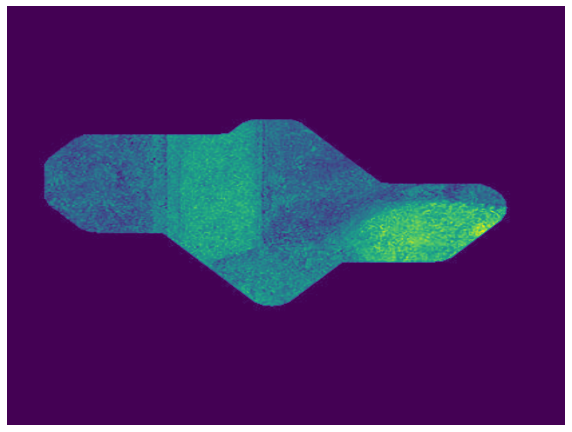

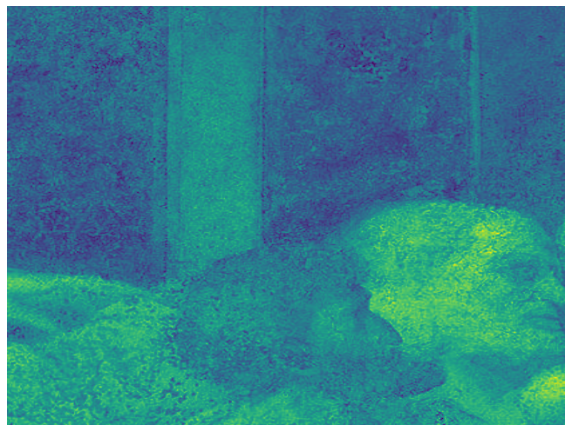

(480, 640)
(480, 640)
(7, 2)
(7, 2)


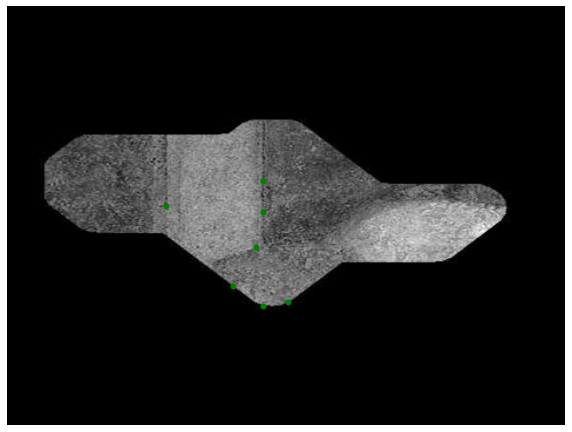

(6, 2)
(6, 2)


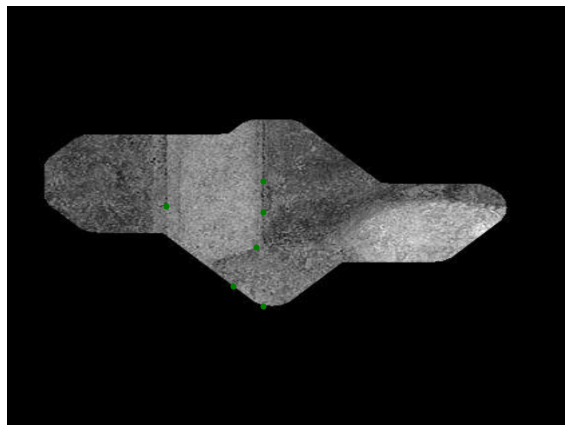

Number of inliers: 4.
[[-6.93503772e-02 -6.23905737e-01  4.01536242e+02]
 [-1.12544349e+00  5.43412904e-01  3.89967036e+02]
 [-5.01196090e-03  4.29728666e-04  2.16563748e+00]]
Transltation : ( 401.5362417764527 , 389.96703649246797 )
Transltation2 : ( -466.7325514045892 , 424.8619872232962 )
Rotation :  -176.47386459169928


"\n        if do_viz:\n            # Visualize the matches.\n            color = cm.jet(mconf)\n            text = [\n                'SuperGlue',\n                'Keypoints: {}:{}'.format(len(kpts0), len(kpts1)),\n                'Matches: {}'.format(len(mkpts0)),\n            ]\n            if rot0 != 0 or rot1 != 0:\n                text.append('Rotation: {}:{}'.format(rot0, rot1))\n\n            # Display extra parameter info.\n            k_thresh = matching.superpoint.config['keypoint_threshold']\n            m_thresh = matching.superglue.config['match_threshold']\n            small_text = [\n                'Keypoint Threshold: {:.4f}'.format(k_thresh),\n                'Match Threshold: {:.2f}'.format(m_thresh),\n                'Image Pair: {}:{}'.format(stem0, stem1),\n            ]\n\n            make_matching_plot(\n                image0, image1, kpts0, kpts1, mkpts0, mkpts1, color,\n                text, viz_path, show_keypoints,\n                fast_viz, opencv_display

In [11]:
for i, pair in enumerate(pairs):
    print('hola')
    name0, name1 = pair[:2]
    stem0, stem1 = Path(name0).stem, Path(name1).stem
    matches_path = output_dir / '{}_{}_matches.npz'.format(stem0, stem1)
    eval_path = output_dir / '{}_{}_evaluation.npz'.format(stem0, stem1)
    viz_path = output_dir / '{}_{}_matches.{}'.format(stem0, stem1, viz_extension)
    viz_eval_path = output_dir / \
        '{}_{}_evaluation.{}'.format(stem0, stem1, viz_extension)

    # Handle --cache logic.
    do_match = True
    do_eval = eval
    do_viz = viz
    do_viz_eval = eval and viz

    if not (do_match or do_eval or do_viz or do_viz_eval):
        timer.print('Finished pair {:5} of {:5}'.format(i, len(pairs)))
        continue
        
    print(pair)

    # If a rotation integer is provided (e.g. from EXIF data), use it:
    if len(pair) >= 5:
        rot0, rot1 = int(pair[2]), int(pair[3])
    else:
        rot0, rot1 = 0, 0
    print(rot0,rot1)
    # Load the image pair.
    image0, inp0, scales0 = read_image(
        input_dir / name0, device, resize, rot0, resize_float)
    image1, inp1, scales1 = read_image(
        input_dir / name1, device, resize, rot1, resize_float)
    if image0 is None or image1 is None:
        print('Problem reading image pair: {} {}'.format(
            input_dir/name0, input_dir/name1))
        exit(1)
    #timer.update('load_image')
    
    plt.figure(figsize=(10, 10))
    plt.imshow(image0)
    plt.axis('off')
    plt.show()


    plt.figure(figsize=(10, 10))
    plt.imshow(image1)
    plt.axis('off')
    plt.show()

    print(image0.shape)
    print(image1.shape)

    if do_match:
        # Perform the matching.
        pred = matching({'image0': inp0, 'image1': inp1})
        pred = {k: v[0].cpu().numpy() for k, v in pred.items()}
        kpts0, kpts1 = pred['keypoints0'], pred['keypoints1']
        matches, conf = pred['matches0'], pred['matching_scores0']
        #timer.update('matcher')

        # Write the matches to disk.
        out_matches = {'keypoints0': kpts0, 'keypoints1': kpts1,
                       'matches': matches, 'match_confidence': conf}
        np.savez(str(matches_path), **out_matches)



    # Keep the matching keypoints.
    valid = matches > -1
    mkpts0 = kpts0[valid]
    mkpts1 = kpts1[matches[valid]]
    mconf = conf[valid]

    print(mkpts0.shape)
    print(mkpts1.shape)
    
    plt.figure(figsize=(10, 10))
    plt.imshow(image0,cmap='gray')
    plt.plot(mkpts0[:, 0], mkpts0[:, 1], "og", markersize=5)  # og:shorthand for green circle
    plt.axis('off')
    plt.show()
    
    mkpts0, mkpts1 = filteringBlackAreaKeypoints(image0,mkpts0,mkpts1)
    print(mkpts0.shape)
    print(mkpts1.shape)
    
    plt.figure(figsize=(10, 10))
    plt.imshow(image0,cmap='gray')
    plt.plot(mkpts0[:, 0], mkpts0[:, 1], "og", markersize=5)  # og:shorthand for green circle
    plt.axis('off')
    plt.show()
    
    
    np.random.seed(0)
    model1, inliers = ransac(
        (mkpts0, mkpts1),
        ProjectiveTransform, min_samples=4,
        residual_threshold=4, max_trials=10000
    )
    n_inliers = np.sum(inliers)
    print('Number of inliers: %d.' % n_inliers)
    inlier_keypoints_left = [cv2.KeyPoint(point[0], point[1], 1) for point in mkpts0[inliers]]
    inlier_keypoints_right = [cv2.KeyPoint(point[0], point[1], 1) for point in mkpts1[inliers]]
    placeholder_matches = [cv2.DMatch(idx, idx, 1) for idx in range(n_inliers)]
    
    '''    
    print(type(image0))
    print(image0.shape)
    
    image0 = imageio.core.util.Array(image0)
    image1 = imageio.core.util.Array(image1)
    print(type(image0))
    print(image0.shape)
    '''
    #image_r1 = cv2.drawMatches(image0, inlier_keypoints_left, image1, inlier_keypoints_right, placeholder_matches, None)
        
    print(model1.params)
    T_x = model1.params[0,2]*model1.params[0,0]+model1.params[1,2]*model1.params[1,0]
    T_y = model1.params[1,2]*model1.params[0,0]-model1.params[0,2]*model1.params[1,0]

    print('Transltation : (',model1.params[0,2],',', model1.params[1,2],')')
    print('Transltation2 : (',T_x,',', T_y,')')
    print('Rotation : ', -np.angle(model1.params[0,0]+model1.params[1,0]*1j)*180/np.pi-270)
    

    '''   
    
    plt.figure(figsize=(10, 10))
    plt.imshow(image_r1)
    plt.axis('off')
    plt.show()
    '''
    
    
    
        
'''
        if do_viz:
            # Visualize the matches.
            color = cm.jet(mconf)
            text = [
                'SuperGlue',
                'Keypoints: {}:{}'.format(len(kpts0), len(kpts1)),
                'Matches: {}'.format(len(mkpts0)),
            ]
            if rot0 != 0 or rot1 != 0:
                text.append('Rotation: {}:{}'.format(rot0, rot1))

            # Display extra parameter info.
            k_thresh = matching.superpoint.config['keypoint_threshold']
            m_thresh = matching.superglue.config['match_threshold']
            small_text = [
                'Keypoint Threshold: {:.4f}'.format(k_thresh),
                'Match Threshold: {:.2f}'.format(m_thresh),
                'Image Pair: {}:{}'.format(stem0, stem1),
            ]

            make_matching_plot(
                image0, image1, kpts0, kpts1, mkpts0, mkpts1, color,
                text, viz_path, show_keypoints,
                fast_viz, opencv_display, 'Matches', small_text)

            timer.update('viz_match')
'''

In [8]:
print(inp0.shape)

torch.Size([1, 1, 480, 640])
